# Contextual Bandits Agent with Policy Gradient Method (Stochastic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from main import stochastic_training_notebook
from Environment import ScoreFunction, DecisionRule

In [2]:
learning_rate_theta = 3e-4
learning_rate_wv = 1e-4
memory_size = 16
batch_size = 16
training_episodes = int(1e6)
decay_rate = 0
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'
learning_std = False
fixed_std = 0.3
# Bucket parameters
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3
prior_red_list = [0.7, 0.3]
# prior_red_list = None
agent_num=5
action_num=1
preferred_colour_pr_list = [0.8, 0.2]
score_func = ScoreFunction.LOG
decision_rule = DecisionRule.DETERMINISTIC
agent_list = []
evaluation_step = 1

system_accumulated_reward = stochastic_training_notebook(agent_list, learning_rate_theta, learning_rate_wv,
                             memory_size, batch_size, training_episodes,
                             decay_rate, beta1, beta2, algorithm, learning_std,
                             fixed_std, pr_red_ball_red_bucket, pr_red_ball_blue_bucket,
                             prior_red_list, agent_num, action_num, score_func, decision_rule, 
                             preferred_colour_pr_list, evaluation_step)

agent0
learning_rate_theta= 0.0003  learning_rate_wv= 0.0001
memory_size= 16  standard deviation= 0.3
Updating weights with regular algorithm.
agent1
learning_rate_theta= 0.0003  learning_rate_wv= 0.0001
memory_size= 16  standard deviation= 0.3
Updating weights with regular algorithm.
agent0
learning_rate_theta= 0.0003  learning_rate_wv= 0.0001
memory_size= 16  standard deviation= 0.3
Updating weights with regular algorithm.
agent1
learning_rate_theta= 0.0003  learning_rate_wv= 0.0001
memory_size= 16  standard deviation= 0.3
Updating weights with regular algorithm.
agent2
learning_rate_theta= 0.0003  learning_rate_wv= 0.0001
memory_size= 16  standard deviation= 0.3
Updating weights with regular algorithm.


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [3]:
len(agent_list)

5

In [4]:
print(system_accumulated_reward/training_episodes)

0.0


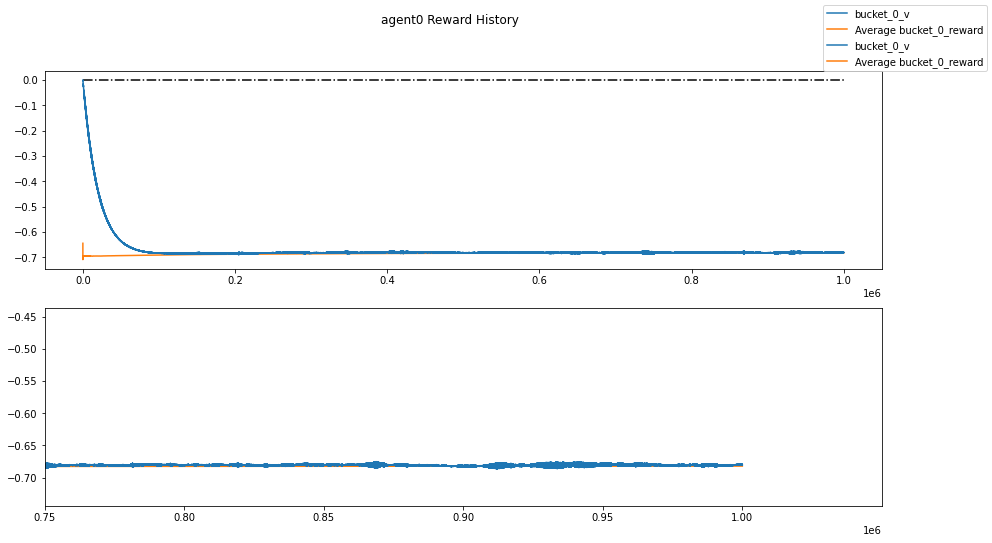

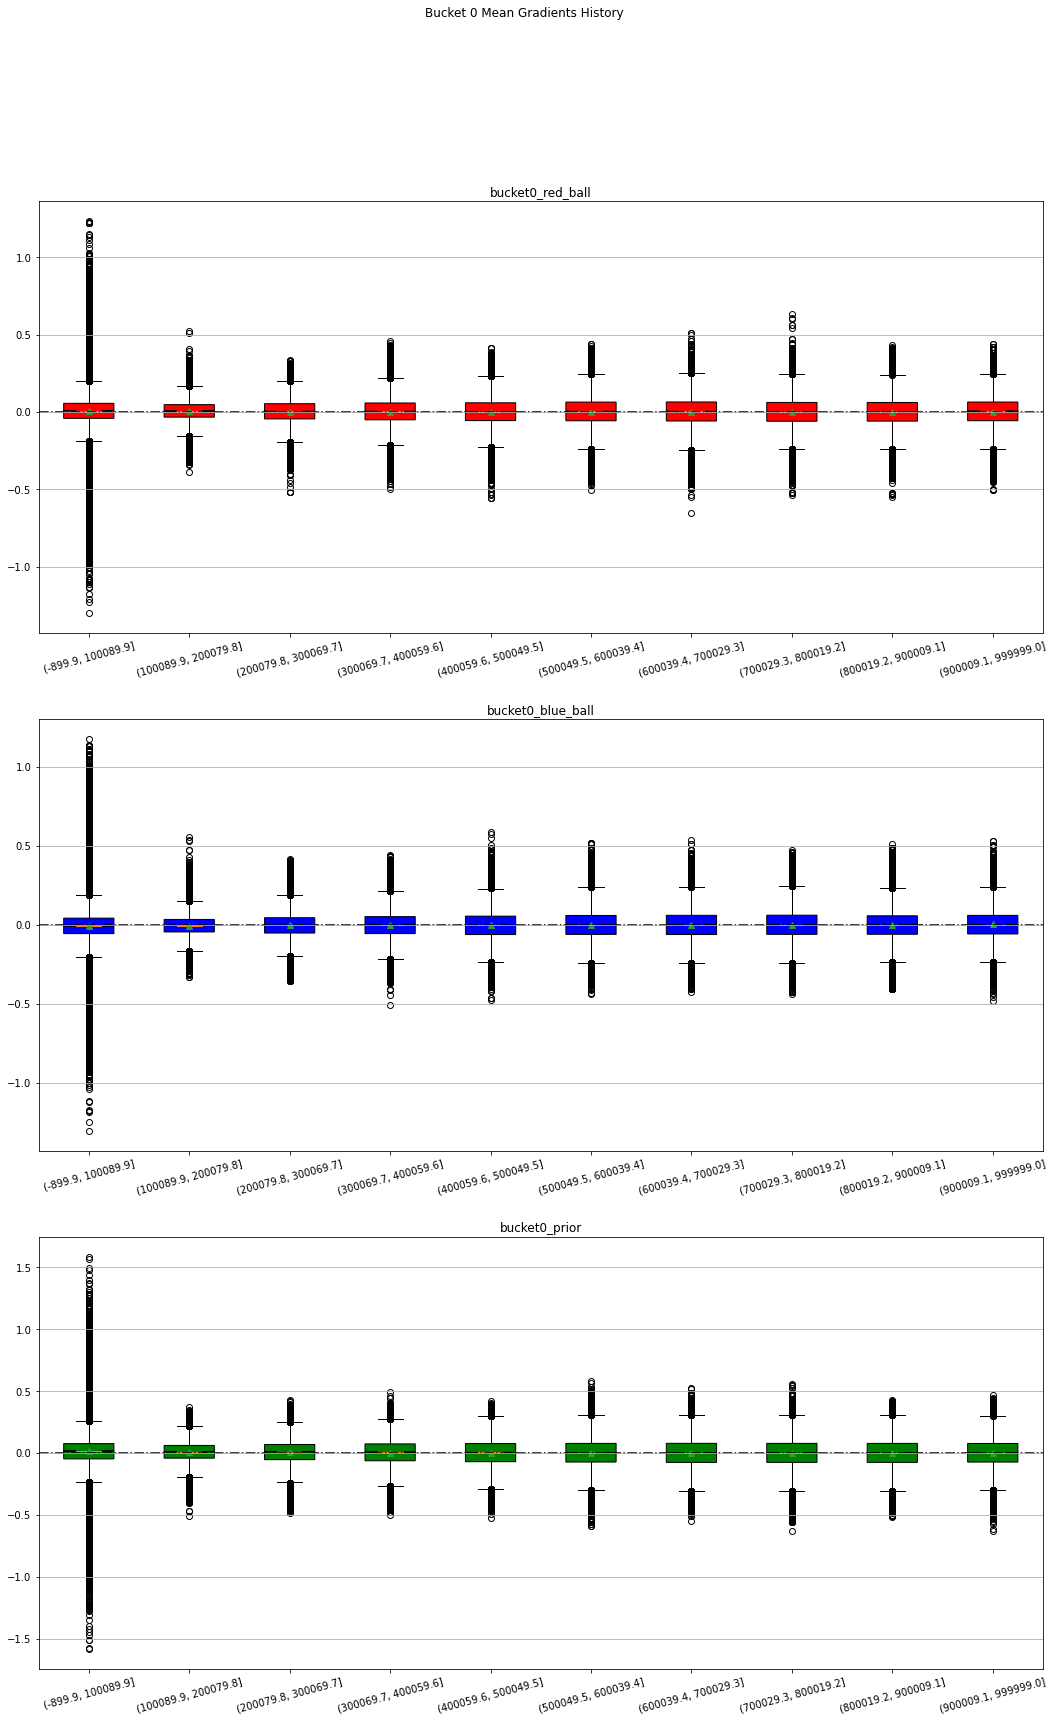

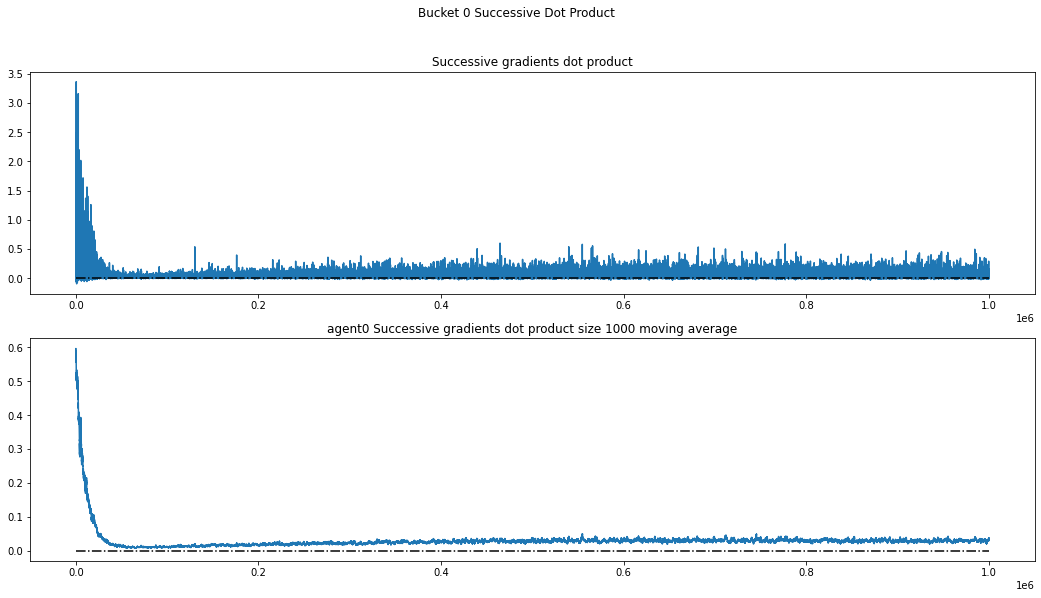

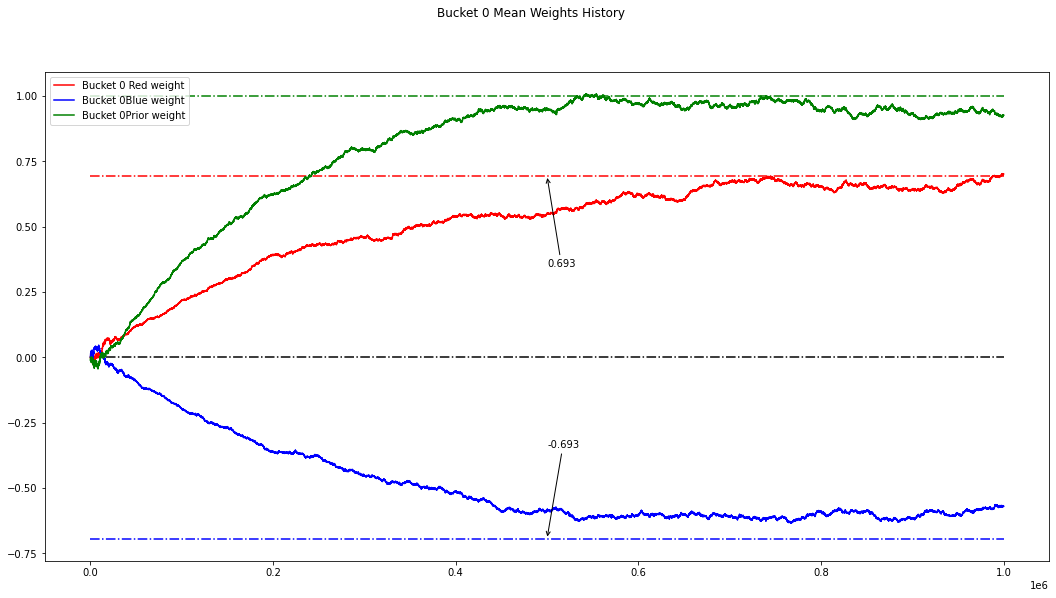

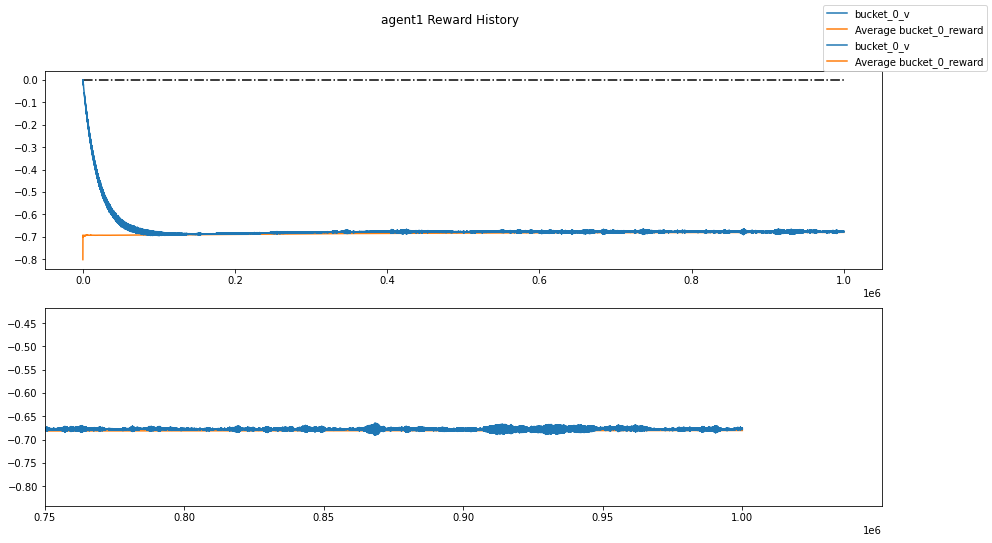

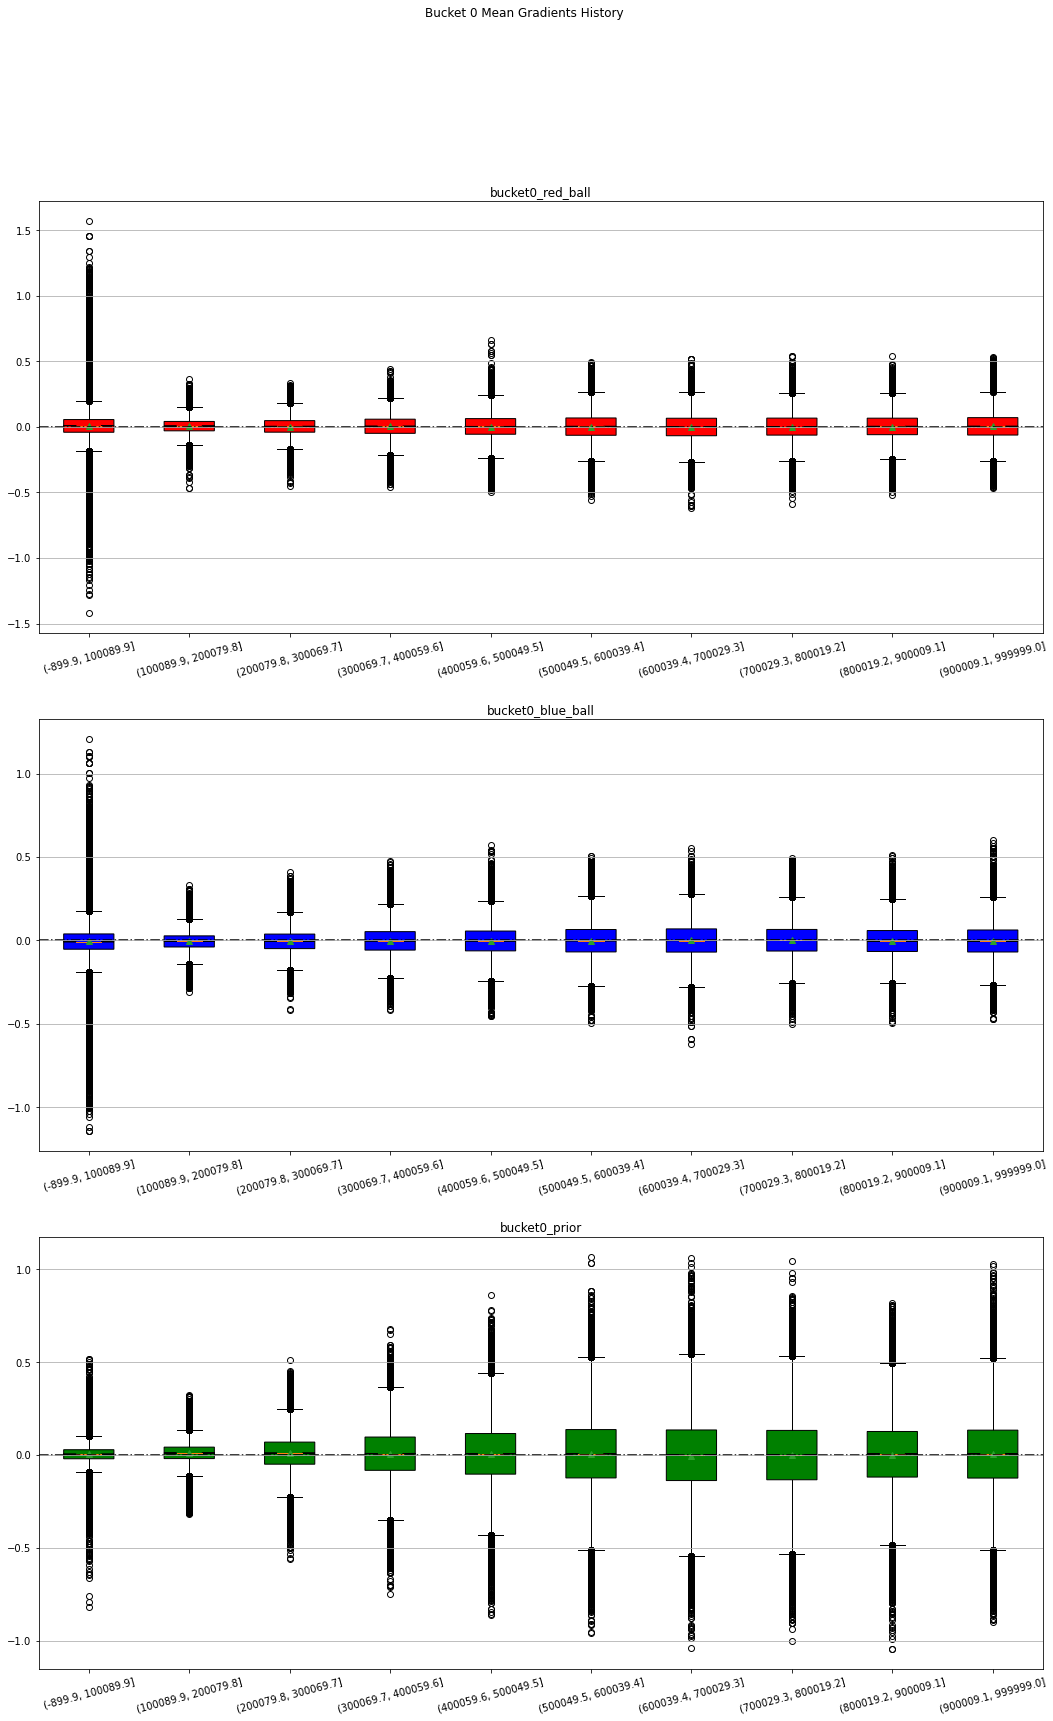

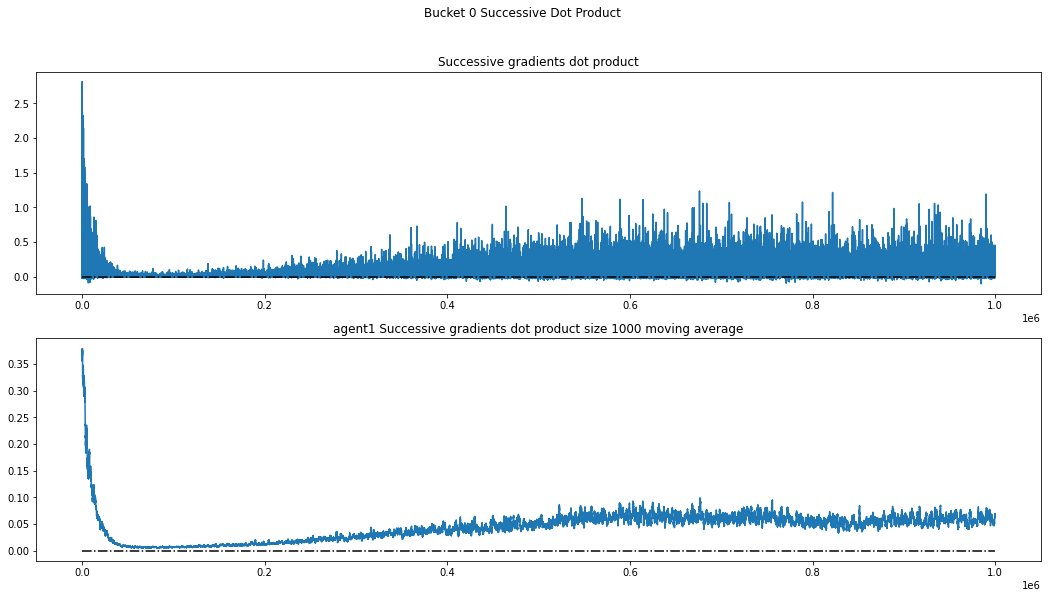

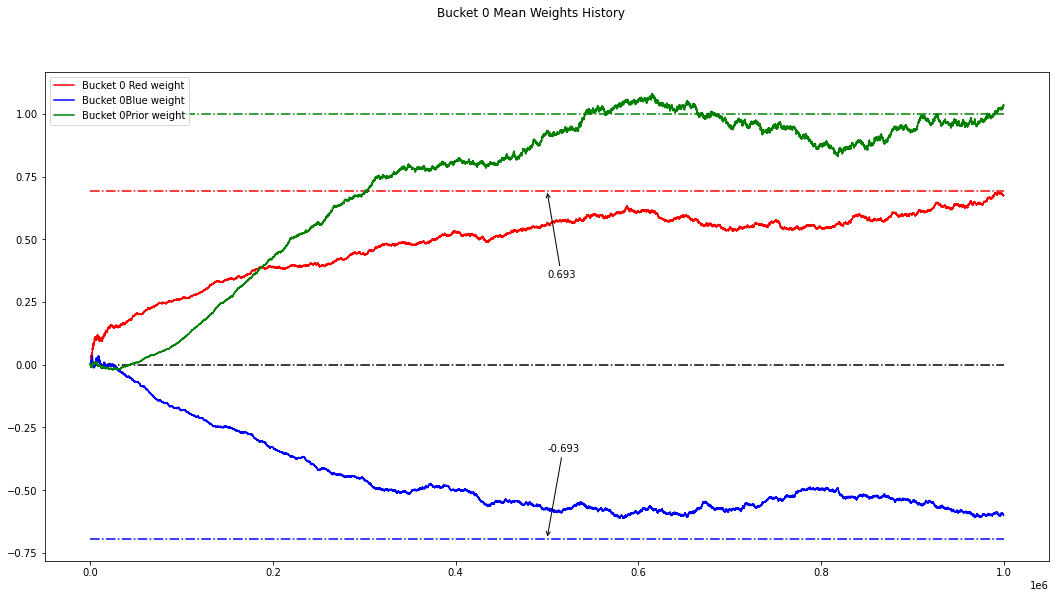

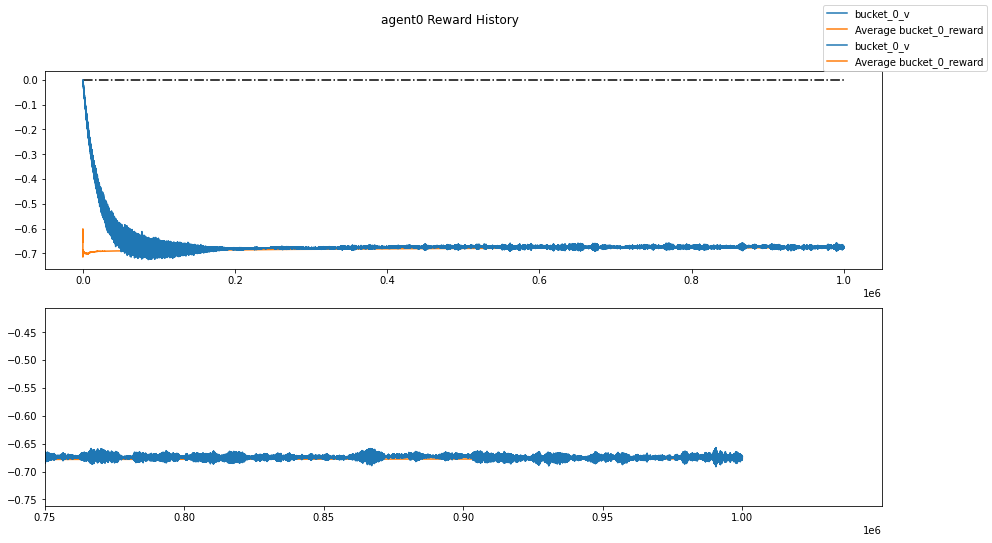

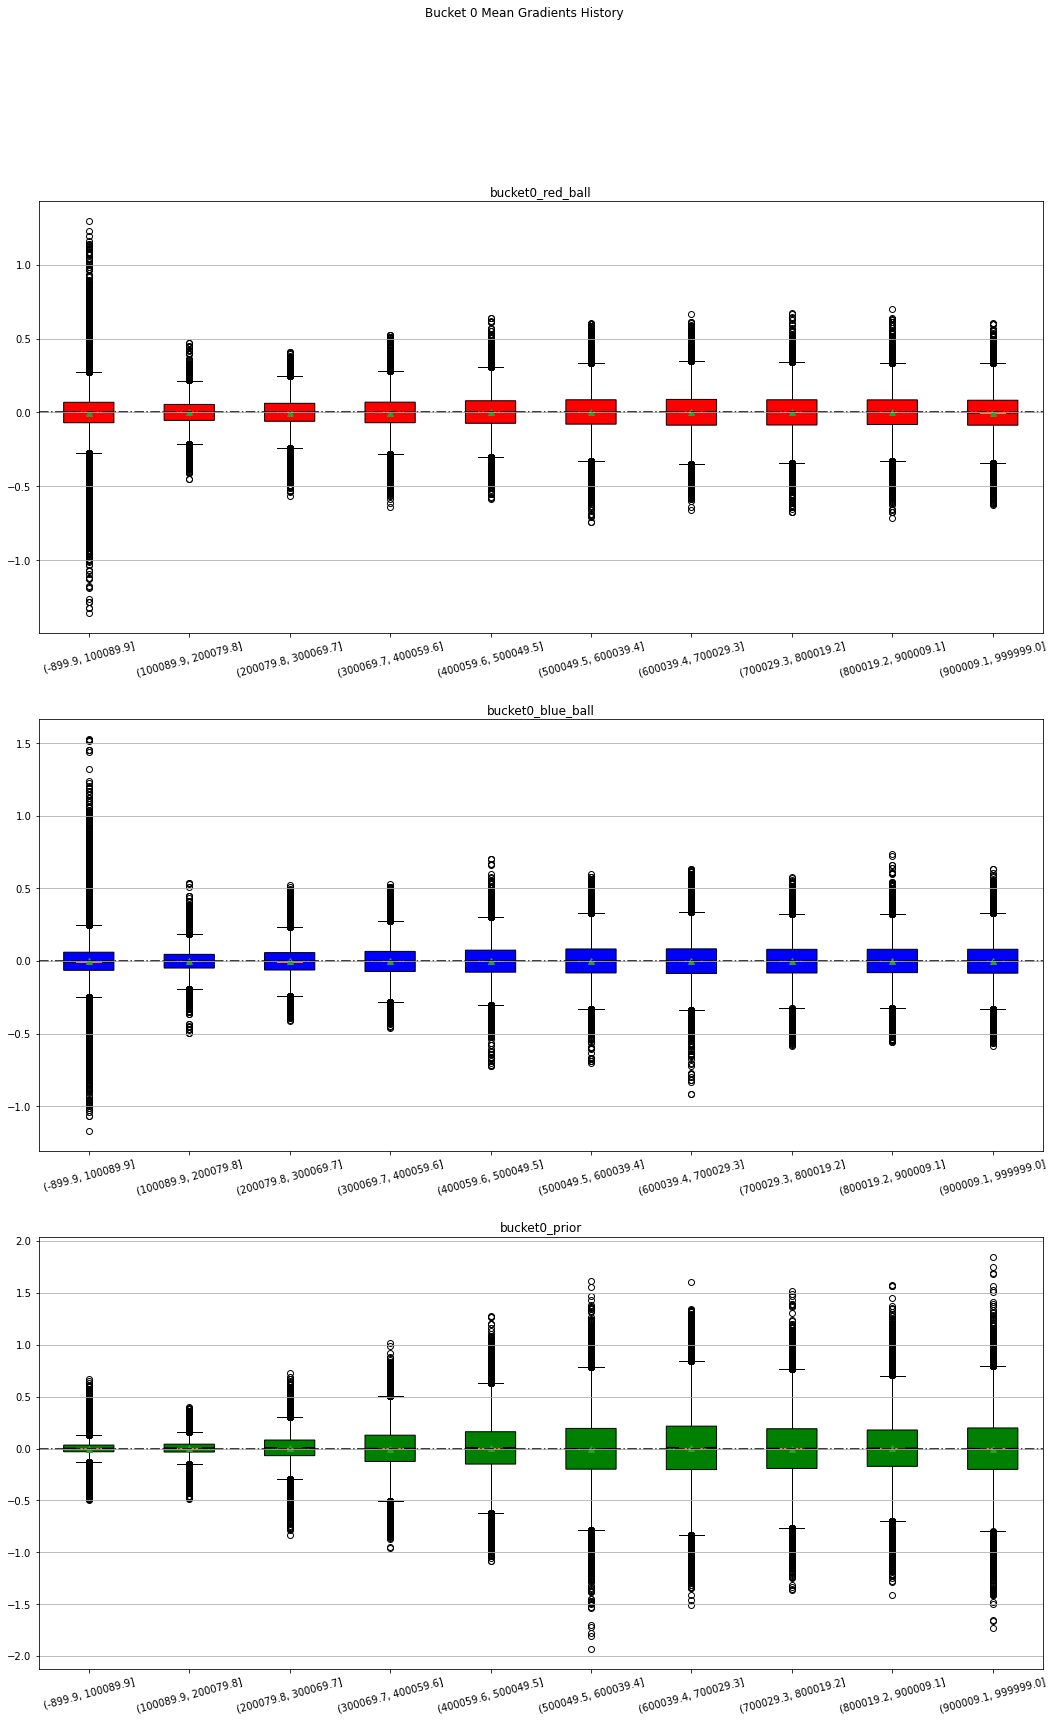

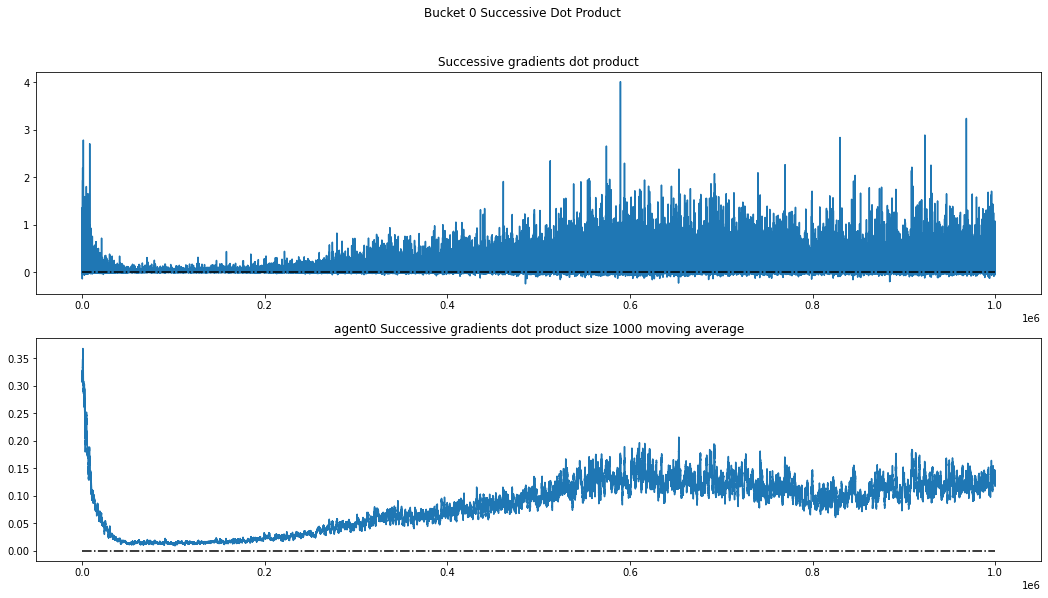

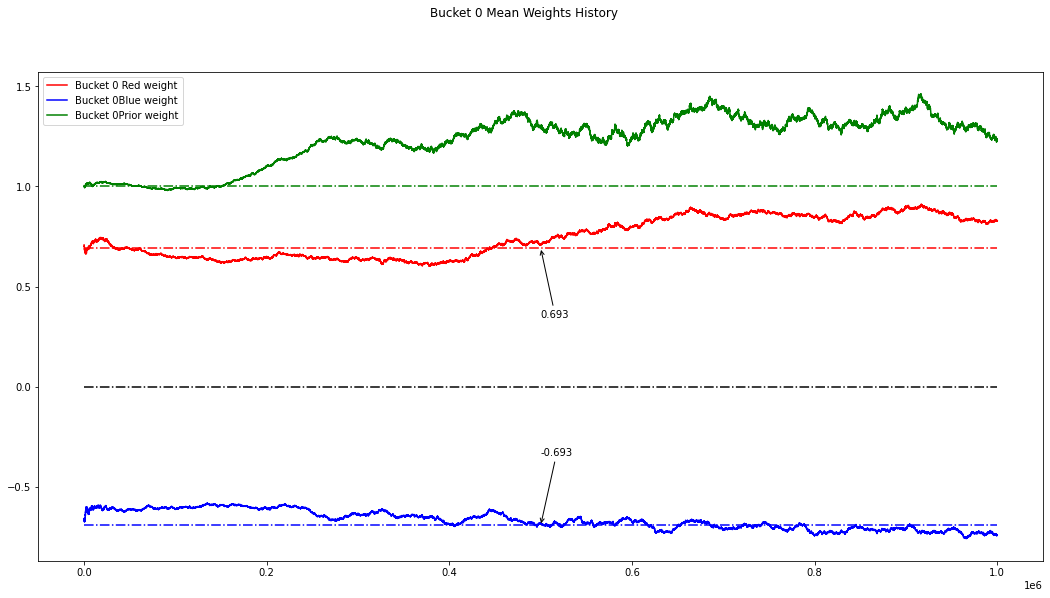

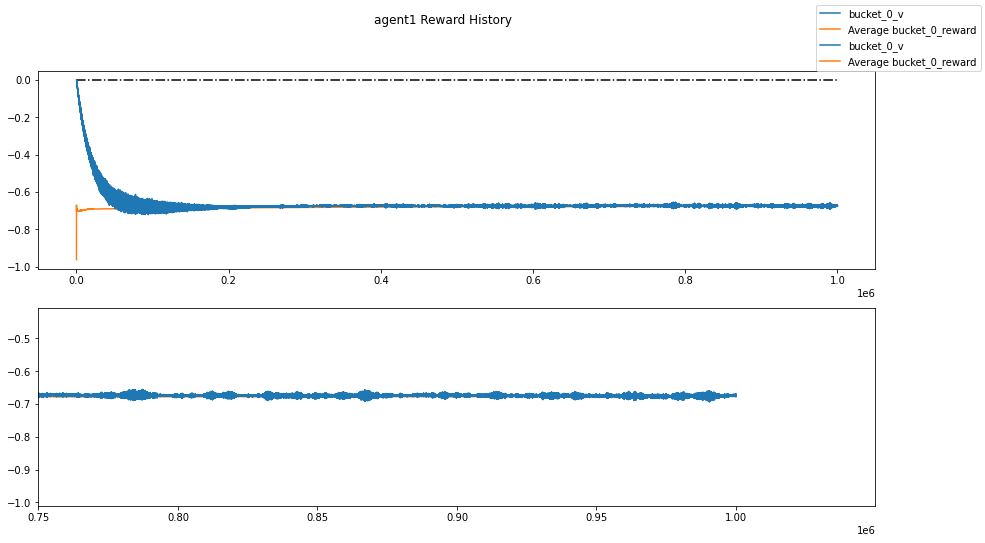

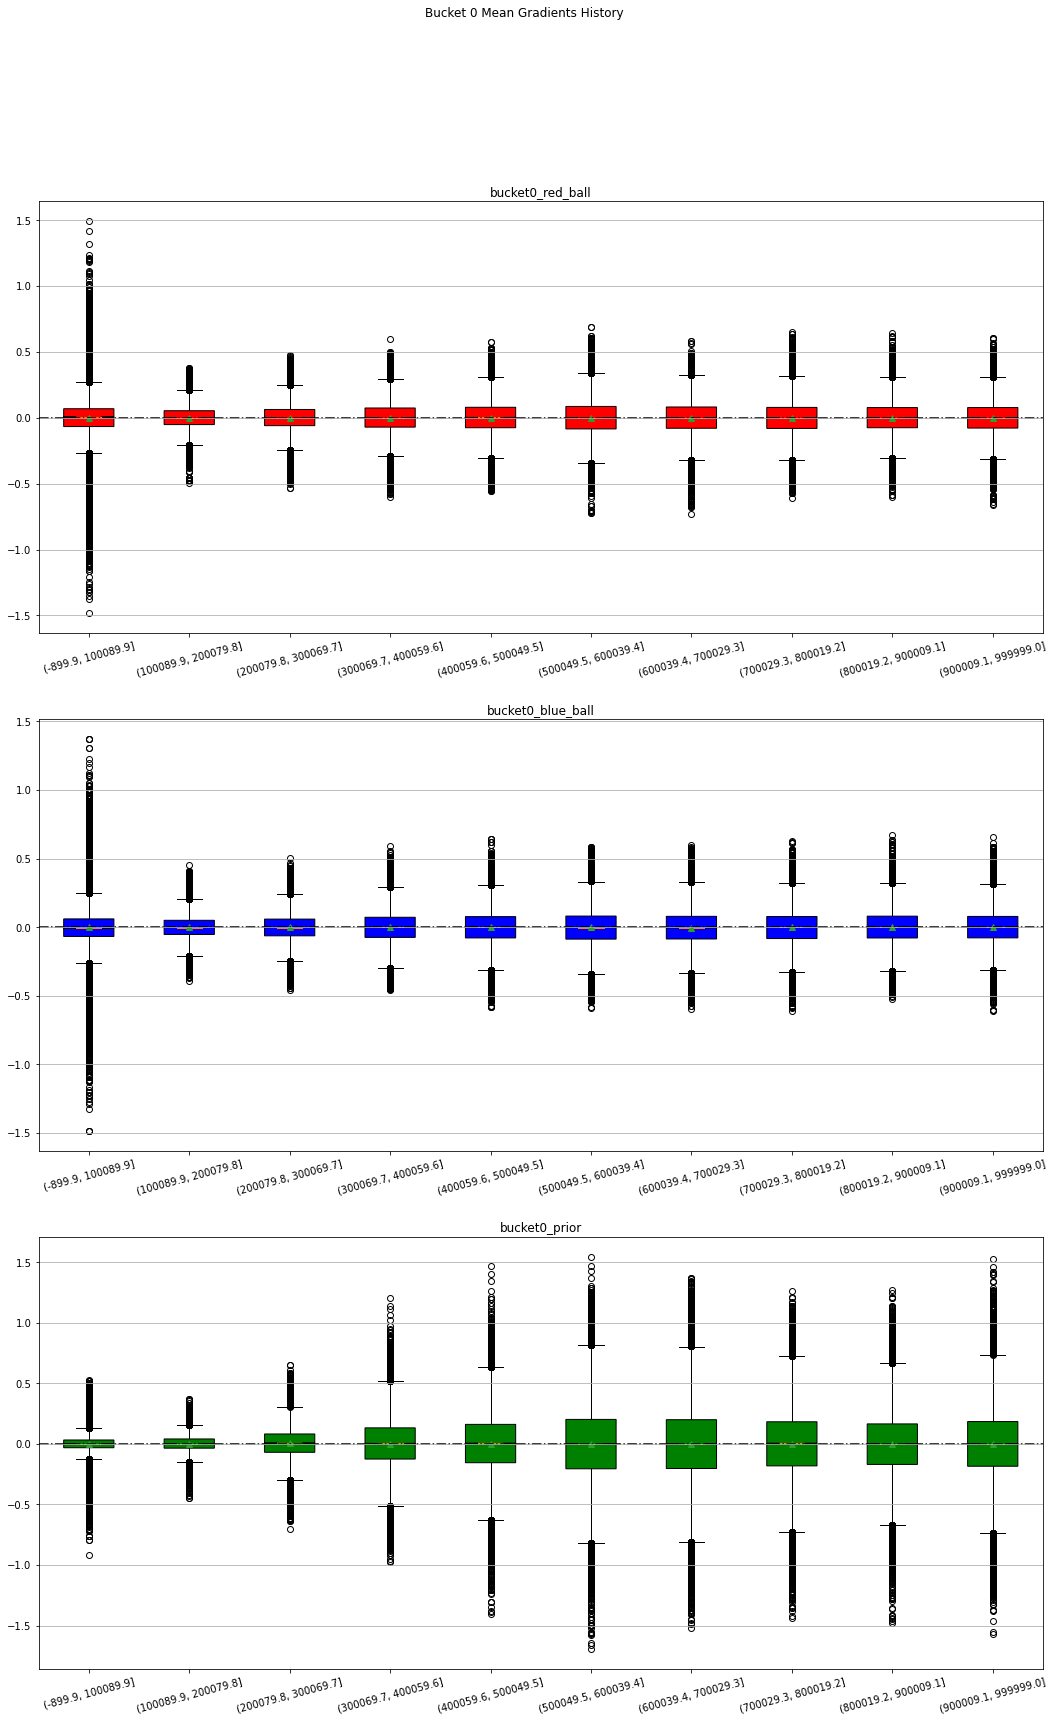

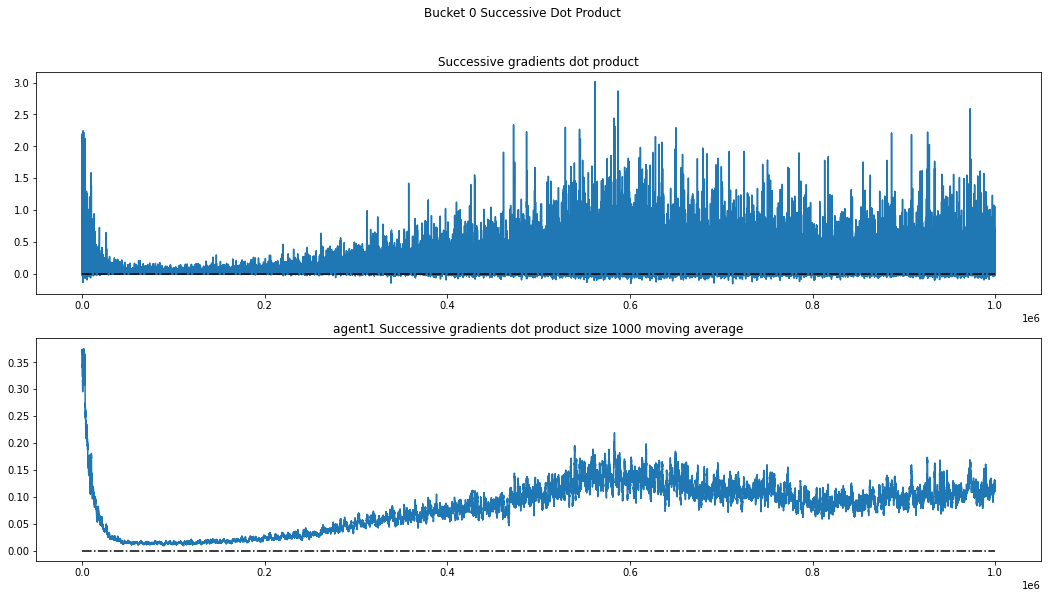

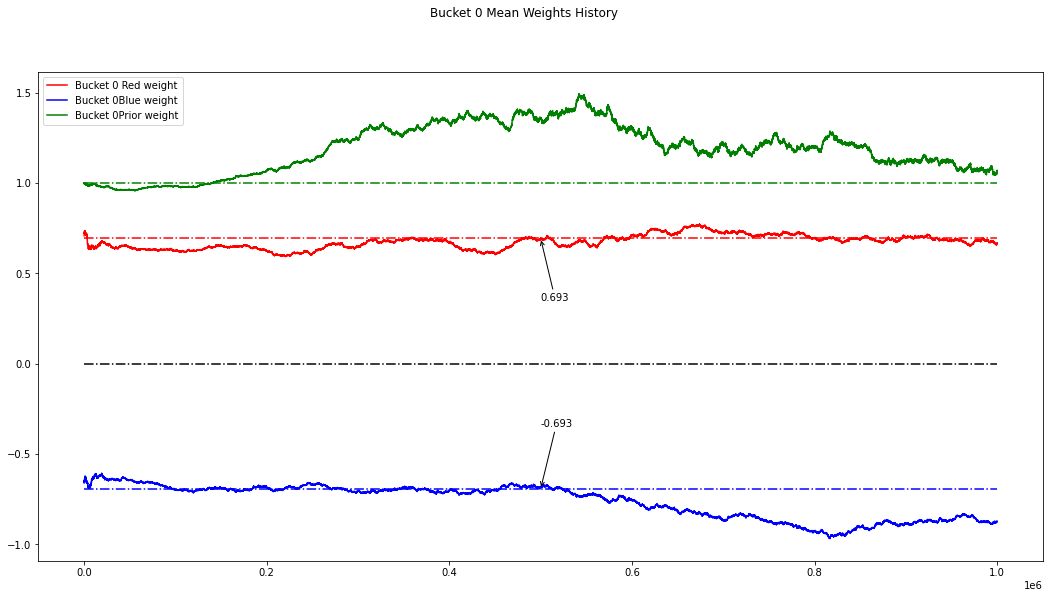

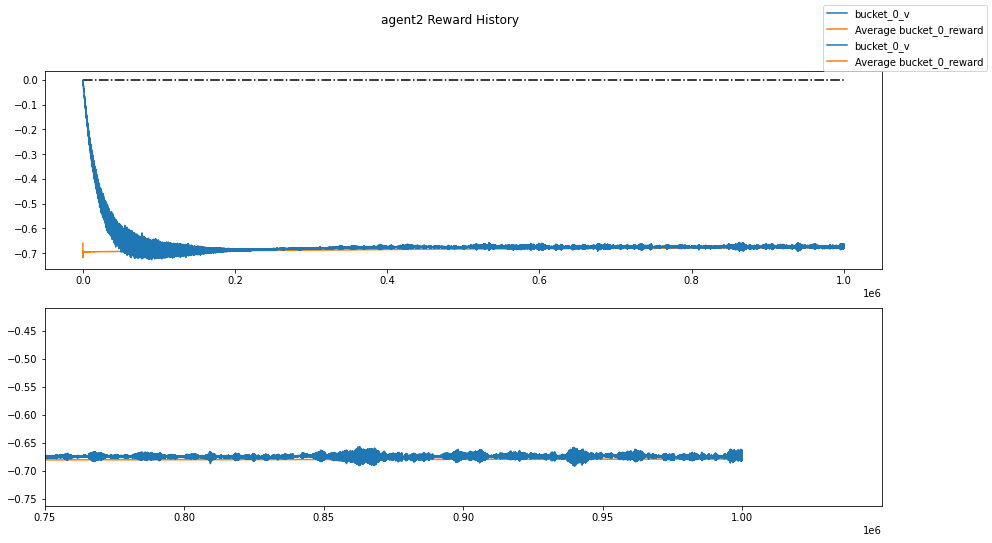

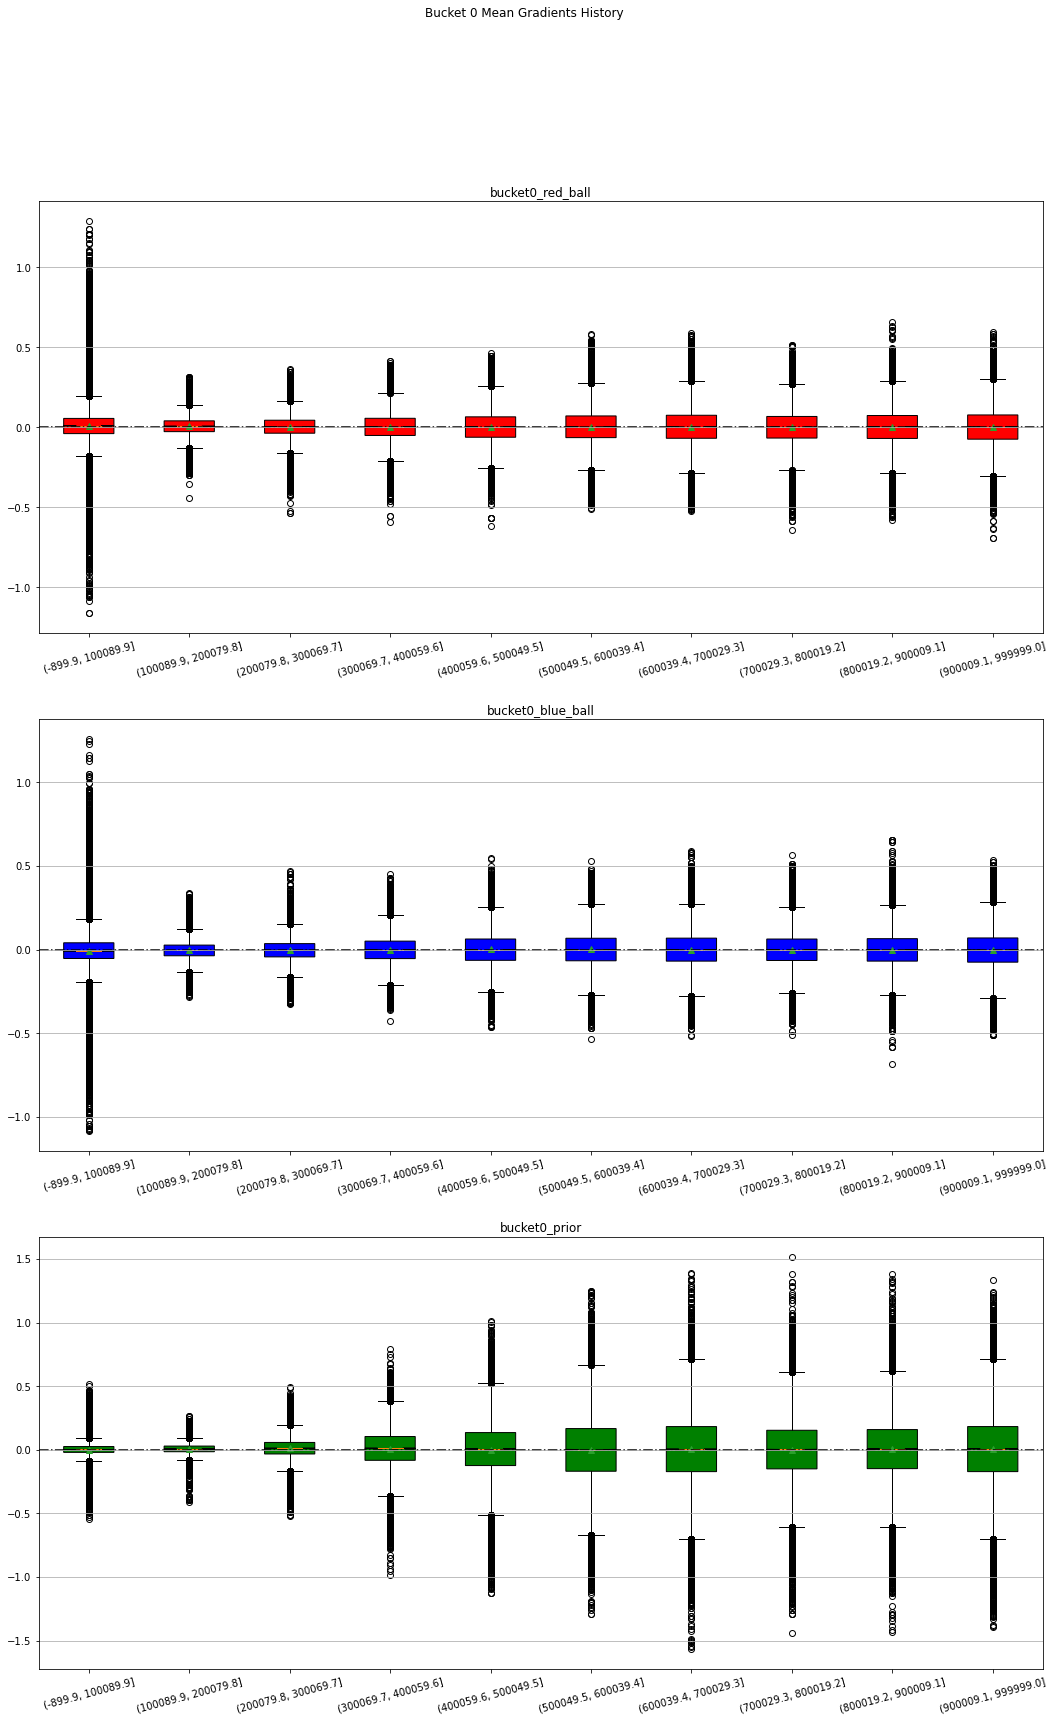

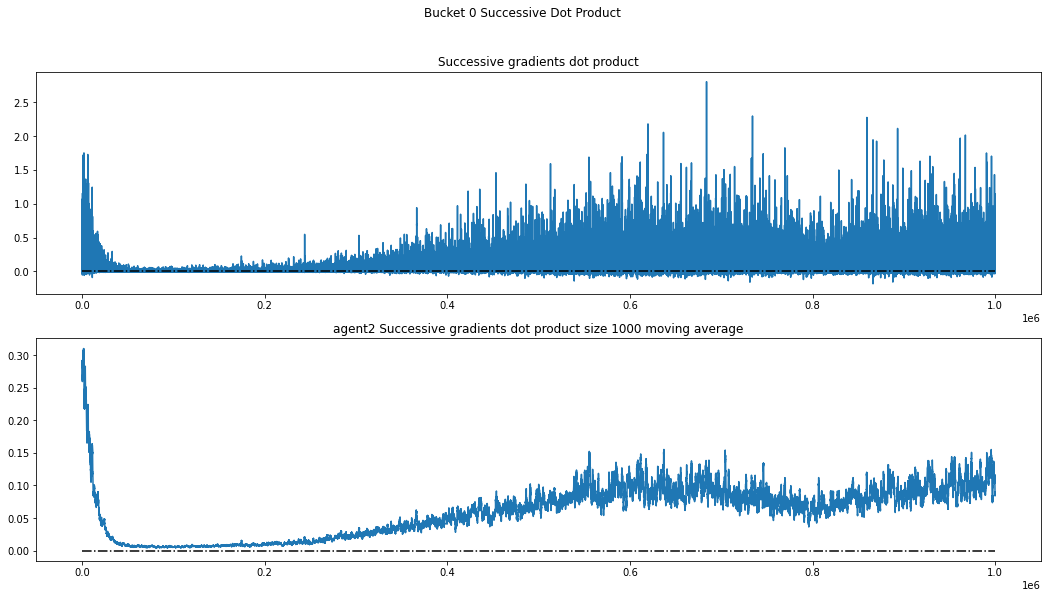

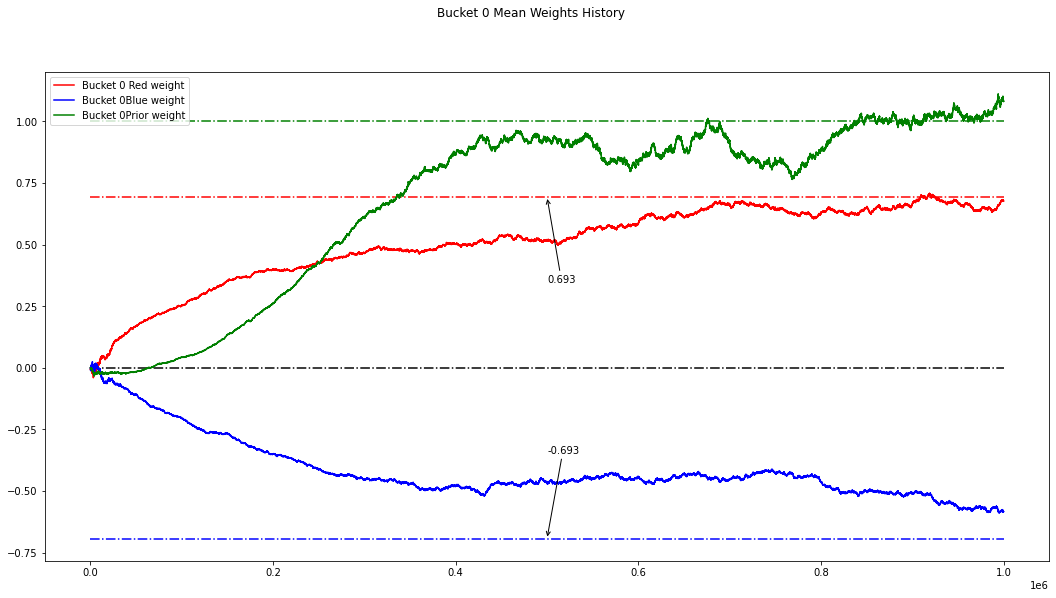

In [5]:
for agent in agent_list:
    agent.reward_history_plot()
#     agent.report_history_plot()
    agent.mean_gradients_history_plot()
    agent.mean_gradients_successive_dot_product_plot()
#     agent.mean_history_plot()
    agent.mean_weights_history_plot()
    agent.std_gradients_history_plot()
    agent.std_history_plot()

In [ ]:
reward_history_df = agent_list[2].reward_history_dataframe()

In [ ]:
reward_history_df

In [ ]:
reward_history_df_df_history_df

In [ ]:
report_history_df = agent_list[0].report_history_dataframe()

In [ ]:
report_history_df.tail(20)

In [ ]:
report_history_df = agent_list[2].report_history_dataframe()
report_history_df.tail(20)

In [ ]:
import math
from scipy import stats
from scipy.special import logit, expit
from Environment import expected_log_reward_red_ball, analytical_best_report_ru_rs

In [ ]:
mu = 0
sigma = 0.2
prior_red = 0.5
colours = ['red', 'blue', 'yellow', 'green', 'purple']
variance = np.square(sigma)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
z = np.linspace(mu-2*sigma, mu+2*sigma, 5)
fig, axs = plt.subplots(5, figsize=(14, 4*5))
axs[0].plot(x, stats.norm.pdf(x, mu, sigma))
axs[0].vlines(z, ymin=0, ymax=np.max(stats.norm.pdf(x=x, loc=mu, scale=sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(z, zip(z, [0]*5)):
    axs[0].annotate('%.3f'%value, xy=coord)
axs[1].plot(expit(x), stats.norm.pdf(x, mu, sigma))
axs[1].vlines(expit(z), ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(expit(z), zip(expit(z), [0]*5)):
    axs[1].annotate('%.3f'%value, xy=coord)
axs[2].plot(np.log(expit(x))-np.log(1/2), stats.norm.pdf(x, mu, sigma))
# axs[2].plot(np.log(1/2) - np.log(expit(x)), stats.norm.pdf(x, mu, sigma))
axs[2].vlines(np.log(expit(z))-np.log(1/2), ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(np.log(expit(z))-np.log(1/2), zip(np.log(expit(z))-np.log(1/2), [0]*5)):
    axs[2].annotate('%.3f'%value, xy=coord)
axs[3].plot(expit(x) - (np.square(expit(x)) + np.square(1 - expit(x)))/2 - 0.25, stats.norm.pdf(x, mu, sigma))
axs[3].vlines(expit(z) - (np.square(expit(z)) + np.square(1 - expit(z)))/2 - 0.25, ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(expit(z) - (np.square(expit(z)) + np.square(1 - expit(z)))/2 - 0.25, zip(expit(z) - (np.square(expit(z)) + np.square(1 - expit(z)))/2 - 0.25, [0]*5)):
    axs[3].annotate('%.3f'%value, xy=coord)
actual_pr_ru_rs = analytical_best_report_ru_rs(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
expected_init = expected_log_reward_red_ball(actual_pr_ru_rs, 1/2, prior_red)
expected_z = expected_log_reward_red_ball(actual_pr_ru_rs, np.array(expit(z)), prior_red)
expected_x = expected_log_reward_red_ball(actual_pr_ru_rs, np.array(expit(x)), prior_red)
# axs[4].plot(expected_x-expected_init, stats.norm.pdf(x, mu, sigma))
# axs[4].vlines(expected_z-expected_init, ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
# for value, coord in zip(expected_z-expected_init, zip(expected_z-expected_init, [0]*5)):
#     axs[4].annotate('%.3f'%value, xy=coord)
axs[4].plot(x, expected_x-expected_init)
axs[4].vlines(z, ymin=np.min(expected_x-expected_init), ymax=np.max(expected_x-expected_init), linestyle='dashdot', colors=colours)
for value, coord in zip(z, zip(z, [np.min(expected_x-expected_init)]*5)):
    axs[4].annotate('%.3f'%value, xy=coord)
plt.show()

In [ ]:
from Environment import expected_log_reward_red_ball, expected_log_reward_blue_ball, analytical_best_report_ru_rs, analytical_best_report_ru_bs

In [ ]:
pr_ru1 = 1/4
pr_ru2 = 3/4
pr_bs_ru = 1/3
pr_bs_bu = 2/3

In [ ]:
r1 = np.linspace(start=0.01, stop=0.99, num=50)
r2 = np.linspace(start=0.01, stop=0.99, num=50)
r1v, r2v = np.meshgrid(r1, r2)
actual_pr_ru_bs1 = analytical_best_report_ru_bs(pr_ru=pr_ru1, pr_bs_ru=pr_bs_ru, pr_bs_bu=pr_bs_bu)
actual_pr_ru_bs2 = analytical_best_report_ru_bs(pr_ru=pr_ru2, pr_bs_ru=pr_bs_ru, pr_bs_bu=pr_bs_bu)
rv = r1v * (r1v > r2v) + r2v * (r1v <= r2v)
actual_pr_ru_bsv = actual_pr_ru_bs1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)
pr_ruv = pr_ru1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)

In [ ]:
rv

In [ ]:
actual_pr_ru_bsv

In [ ]:
def dm_expected_log_reward_blue_ball(pr_ru1, pr_ru2, pr_bs_ru, pr_bs_bu):
    r1 = np.linspace(start=0.01, stop=0.99, num=50)
    r2 = np.linspace(start=0.01, stop=0.99, num=50)
    r1v, r2v = np.meshgrid(r1, r2)
    actual_pr_ru_bs1 = analytical_best_report_ru_bs(pr_ru=pr_ru1, pr_bs_ru=pr_bs_ru, pr_bs_bu=pr_bs_bu)
    actual_pr_ru_bs2 = analytical_best_report_ru_bs(pr_ru=pr_ru2, pr_bs_ru=pr_bs_ru, pr_bs_bu=pr_bs_bu)
    rv = r1v * (r1v > r2v) + r2v * (r1v <= r2v)
    actual_pr_ru_bsv = actual_pr_ru_bs1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)
    pr_ruv = pr_ru1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)
    return r1v, r2v, expected_log_reward_blue_ball(actual_pr_ru_bs=actual_pr_ru_bsv, estimated_pr_ru_bs=rv, pr_ru=pr_ruv)

In [ ]:
r1v, r2v, z = dm_expected_log_reward_blue_ball( pr_ru1, pr_ru2, pr_bs_ru, pr_bs_bu)

In [ ]:
# %matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.contour3D(r1v, r2v, z, 100, cmap='binary')
ax.plot_surface(r1v, r2v, z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('r1')
ax.set_ylabel('r2')
ax.set_zlabel('expectation')
ax.view_init(90, 60)

plt.show()

In [ ]:
pr_ru1 = 1/4
pr_ru2 = 3/4
pr_rs_ru = 2/3
pr_rs_bu = 1/3

In [ ]:
def dm_expected_log_reward_red_ball(pr_ru1, pr_ru2, pr_rs_ru, pr_rs_bu):
    r1 = np.linspace(start=0.01, stop=0.99, num=50)
    r2 = np.linspace(start=0.01, stop=0.99, num=50)
    r1v, r2v = np.meshgrid(r1, r2)    
    actual_pr_ru_rs1 = analytical_best_report_ru_rs(pr_ru=pr_ru1, pr_rs_ru=pr_rs_ru, pr_rs_bu=pr_rs_bu)
    actual_pr_ru_rs2 = analytical_best_report_ru_rs(pr_ru=pr_ru2, pr_rs_ru=pr_rs_ru, pr_rs_bu=pr_rs_bu)   
    rv = r1v * (r1v > r2v) + r2v * (r1v <= r2v)
    actual_pr_ru_rsv = actual_pr_ru_rs1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)
    pr_ruv = pr_ru1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)
    return r1v, r2v, expected_log_reward_red_ball(actual_pr_ru_rs=actual_pr_ru_rsv, estimated_pr_ru_rs=rv, pr_ru=pr_ruv)

r1v, r2v, z = dm_expected_log_reward_red_ball(pr_ru1, pr_ru2, pr_rs_ru, pr_rs_bu)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.contour3D(r1v, r2v, z, 100, cmap='binary')
ax.plot_surface(r1v, r2v, z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('r1')
ax.set_ylabel('r2')
ax.set_zlabel('expectation')
ax.view_init(90, 60)

plt.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure(data=[go.Surface(z=z, x=r1v, y=r2v)])
fig.update_layout(title='Mt Bruno Elevation', autosize=True,
#                   width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
pr_ru1 = 1/4
pr_ru2 = 3/4
pr_rs_ru = 2/3
pr_rs_bu = 1/3

In [ ]:
from numpy.random import Generator, PCG64
def stochastic_decision_rule(r1v, r2v, probabilities, pr_ru1, pr_ru2, pr_rs_ru, pr_rs_bu):
#     generator = Generator(PCG64())
    result_array = np.zeros(r1v.shape)
    r_stack_v = np.dstack((r1v, r2v))
    for i in range(r_stack_v.shape[0]):
        for j in range(r_stack_v.shape[1]):
            r1, r2 = r_stack_v[i][j]
            if r1 > r2:
                pr = probabilities
            else:
                pr = probabilities[::-1]
            actual_pr_ru_rs1 = analytical_best_report_ru_rs(pr_ru=pr_ru1, pr_rs_ru=pr_rs_ru, pr_rs_bu=pr_rs_bu)
            actual_pr_ru_rs2 = analytical_best_report_ru_rs(pr_ru=pr_ru2, pr_rs_ru=pr_rs_ru, pr_rs_bu=pr_rs_bu) 
            result_array[i][j] = expected_log_reward_red_ball(actual_pr_ru_rs=actual_pr_ru_rs1, estimated_pr_ru_rs=r1, pr_ru=pr_ru1)/pr[0] + expected_log_reward_red_ball(actual_pr_ru_rs=pr_ru2, estimated_pr_ru_rs=r2, pr_ru=pr_ru2)/pr[1]
            
    return result_array

In [ ]:
z = stochastic_decision_rule(r1v, r2v, [0.8, 0.2], pr_ru1, pr_ru2, pr_rs_ru, pr_rs_bu)

In [ ]:
actual_pr_ru_rs1 = analytical_best_report_ru_rs(pr_ru=pr_ru1, pr_rs_ru=pr_rs_ru, pr_rs_bu=pr_rs_bu)
actual_pr_ru_rs1

In [ ]:
fig = go.Figure(data=[go.Surface(z=z, x=r1v, y=r2v)])
fig.update_layout(title='Mt Bruno Elevation', autosize=True,
#                   width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()